# Сверточные нейронные сети в PyTorch

Обучаем сверточную нейронную сеть распознавать объекты из набора данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Курс "[Технологии искусственного интеллекта для учителей информатики](https://edu.mipt.ru/ai/it2/)".

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

Определяем инструмент предварительной обработки изображений из набора данных

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Загружаем наборы данных для обучения и тестирования

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)


100%|██████████| 170498071/170498071 [00:02<00:00, 78213312.52it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Создаем загрузчики данных

In [ ]:
# Размер мини-выборки
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Имена классов

In [ ]:
classes = ('самолет', 'машина', 'птица', 'кот',
           'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

Просматриваем примеры изображений



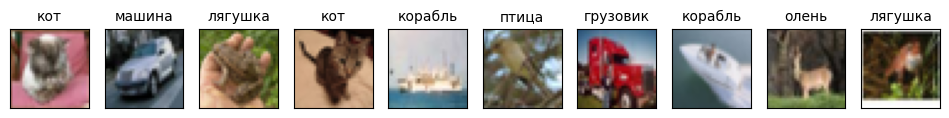

In [ ]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
device

'cuda'

Описываем класс для модели

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

Создаем модель на основе описанного класса

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

## Обучаем модель

Задаем функцию ошибки - категориальная перекрестная энтропия



In [ ]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошиби
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на тестовом наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 10 эпох



In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на тестовом объеме данных
    test(testloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 2.300334  [  256/50000]
Ошибка: 2.050296  [13056/50000]
Ошибка: 1.771594  [25856/50000]
Ошибка: 1.766132  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 44.4%, средняя ошибка: 1.489276 

Эпоха 2
-------------------------------
Ошибка: 1.449128  [  256/50000]
Ошибка: 1.251039  [13056/50000]
Ошибка: 1.216077  [25856/50000]
Ошибка: 1.186636  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 62.2%, средняя ошибка: 1.062233 

Эпоха 3
-------------------------------
Ошибка: 1.056533  [  256/50000]
Ошибка: 0.996837  [13056/50000]
Ошибка: 0.919833  [25856/50000]
Ошибка: 0.814948  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 69.7%, средняя ошибка: 0.874653 

Эпоха 4
-------------------------------
Ошибка: 0.697768  [  256/50000]
Ошибка: 0.652606  [13056/50000]
Ошибка: 0.691556  [25856/50000]
Ошибка: 0.670125  [38656/50000]
Качество на тестовом наборе данных: 


## Сохранение обученной модели



Параметры модели

In [ ]:
model.state_dict()

OrderedDict([('network.0.weight',
              tensor([[[[ 1.4841e-01,  1.9467e-01,  1.7470e-01],
                        [ 1.4846e-01, -5.2501e-02, -1.6255e-01],
                        [-8.6459e-02, -1.7572e-01,  2.4006e-02]],
              
                       [[ 1.0244e-01,  1.2670e-01,  1.2088e-01],
                        [-1.2415e-01,  6.3579e-02,  7.6409e-02],
                        [-4.3448e-02, -1.2623e-01, -2.2354e-02]],
              
                       [[ 6.4044e-02,  1.0401e-01, -8.5364e-02],
                        [ 7.1447e-02,  1.2769e-01, -1.8570e-01],
                        [-4.2597e-04, -1.2496e-01, -1.8893e-01]]],
              
              
                      [[[-1.7925e-02,  2.2497e-01, -1.4847e-02],
                        [-1.1283e-02, -7.6696e-03, -2.2435e-02],
                        [ 5.7811e-02, -8.8593e-02, -6.0490e-02]],
              
                       [[-9.9372e-02,  8.9845e-02,  6.8081e-02],
                        [-6.5693e-03,  1.

In [ ]:
torch.save(model.state_dict(), "model.pth")

## Загрузка модели



In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Распознавание изображений из тестового набора данных



In [ ]:
model.eval()

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
x, y = testset[3]

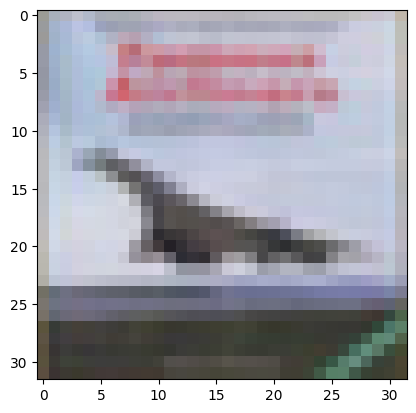

In [ ]:
img = x / 2 + 0.5
plt.imshow(img.permute(1, 2, 0))

Запускаем распознавание

In [ ]:
with torch.no_grad():
    x = x.unsqueeze(0).to(device)
    pred = model(x)

Результаты распознавания

In [ ]:
pred

tensor([[ 6.8175, -4.4769,  0.1051, -3.9649, -0.3448, -5.5979, -5.9165, -4.4270,
         -0.4319, -2.7922]], device='cuda:0')

Номер класса

In [ ]:
pred[0].argmax(0)

tensor(0, device='cuda:0')

Название класса

In [ ]:
classes[pred[0].argmax(0)]

'самолет'

Правильный ответ

In [ ]:
y

0

In [ ]:
classes[y]

'самолет'

## Распознаем дополнительное изображение

In [ ]:
from PIL import Image

In [ ]:
img = Image.open("ship.jpg")

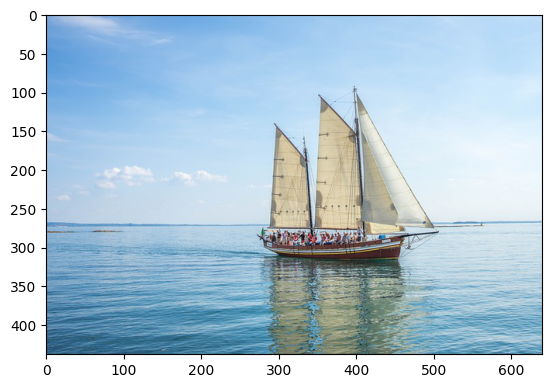

In [ ]:
plt.imshow(img)

## Выполняем предварительную обработку изображения

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch = transform(img).unsqueeze(0)

In [ ]:
batch

tensor([[[[ 0.0667,  0.2549,  0.3882,  ...,  0.4588,  0.4745,  0.4745],
          [-0.0980, -0.0039,  0.1373,  ...,  0.4353,  0.4431,  0.4667],
          [-0.1765, -0.1216, -0.0275,  ...,  0.4510,  0.4667,  0.4824],
          ...,
          [-0.4353, -0.4353, -0.4196,  ..., -0.0275, -0.0510, -0.0353],
          [-0.5765, -0.5765, -0.5451,  ...,  0.1294,  0.1529,  0.1529],
          [-0.6157, -0.5843, -0.5765,  ..., -0.1137, -0.0902, -0.0824]],

         [[ 0.3569,  0.4745,  0.5529,  ...,  0.7176,  0.7333,  0.7255],
          [ 0.2863,  0.3490,  0.4275,  ...,  0.7176,  0.7176,  0.7255],
          [ 0.2549,  0.2941,  0.3490,  ...,  0.7255,  0.7333,  0.7490],
          ...,
          [-0.0431, -0.0275, -0.0039,  ...,  0.3725,  0.3569,  0.3647],
          [-0.1922, -0.1765, -0.1451,  ...,  0.4510,  0.4667,  0.4667],
          [-0.2314, -0.2000, -0.1765,  ...,  0.2941,  0.3098,  0.3176]],

         [[ 0.7255,  0.7647,  0.8039,  ...,  0.9451,  0.9529,  0.9529],
          [ 0.7098,  0.7333,  

## Выполняем классификацию изображения

Выполняем распознавание

In [ ]:
batch = batch.to(device)

In [ ]:
prediction = model(batch).squeeze(0)

Результаты распознавания

In [ ]:
prediction

tensor([-2.8165, -7.0918, -2.5748, -4.0060, -2.6877, -5.4187, -4.3926, -4.7838,
         9.5139, -4.0081], device='cuda:0', grad_fn=<SqueezeBackward1>)

Выбираем класс с максимальной вероятностью

In [ ]:
class_id = prediction.argmax().item()

In [ ]:
class_id

8

Название класса

In [ ]:
classes[class_id]

'корабль'